***
$$\mathbf{\text{Simulation/Experimental Output Processing and ML-MF Correction}}$$<br>
$$\mathbf{\text{Author: Kenneth Kusima}}$$<br>
$\mathbf{\text{Date: 06/01}}$<br>

#### Note sw: Switching -> CO<->O2 ; CO*<->O* To match KMC specnum file


#### It also |uses the MKM input files that match this order *_sw

#### As well as the new test set KMC_NonDynamic_Data_iCovg_iRates_sw

#### Switch the pressures accordingly CO <-> O2

***
$\mathbf{\text{Model being explored: Simple 4-step CO Oxidation}}:$<br>

${\text{Corresponding Micro Kinetic Model}}:$<br>
***
$$\require{mhchem}$$       
---
Overall Reaction: 
$$ CO + \frac{1}{2} O_2 {\stackrel{\tiny{\textrm{Pt/Pd}}}{\rightleftharpoons}} CO_2 $$
---
Note Reations in the Reaction Mechanism may be reversible or irreversible

Reaction 1:&emsp;Adsorption of CO

$$ CO + * \rightleftharpoons CO^{*} $$

Reaction 2:&emsp;Adsorption of $O_2$

$$ O_2 + * \rightleftharpoons {O_2}^{*} $$

Reaction 3:&emsp;Dissociation of ${O_2}^*$ 

$$ {O_2}^* + * \rightleftharpoons 2{O}^* $$

Reaction 4:&emsp;Surface Reaction of $CO$ and $O_2$  

$$ {CO}^{*} + {O}^{*} \rightleftharpoons CO_2 + 2* $$

In [1]:
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil

***

<a id="top"></a><br>
 # Table of Contents  
1. [Loading in the labeled simulation folders](#1)   
    1. [Checking all simulations were completed as expected](#1.1)
1. [Developing ML Training Dataset for rate correction](#2) 
    1. [Generating Experimental Data Dictionary](#2.1) 
    1. [Generating MF-MKM Data Dictionary](#2.2)     
    1. [Creating Features](#2.3)      
        C1. [Log ratio](#2.3.1)     
        C2. [Percent Difference](#2.3.2)    
        
    1. [Creating Input/Feature Tensor](#2.4)
    1. [Extracting Full X (Feature) and Y(Target) datasets](#2.5)
    1. [Performing Train/Test X and Y Split datasets](#2.6)
1. [Modelling](#3)
1. [Describing Possible Machine Learning Model Algorithms](#4)
1. [Selecting and Training the Model](#5)
1. [Importing External/Experimental Data to be used in the model](#6)
    1. [Generating corresponding MF-MKModel](#6.1) 
    1. [Predicting Machine-Learned Mean-Field Corrections](#6.2)
    1. [ML Correction to MF-MKModel](#6.3)
    1. [Evaluating the ML model prediction](#6.4)
    1. [Plotting results](#6.5)
    
1. [Exploring and Evaluating possible ML options](#7)

***
<a id="1"></a> 
## 1. Loading in the labeled simulation folders
<a href="#top">Back to top</a>

In [2]:
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil

In [3]:
os.getcwd()

'/Users/klkusima/Desktop/RASH_Research/CO_ox/Kinetics/OOP_Kinetics/MiKi/OOP7_Curve_Fit_OPTIM/CO_adsorption_desorption'

In [4]:
%%time
os.chdir('NONLATERAL')
Sim_folder_names = []
i = 0
for file in glob.glob("*bar"):
    Sim_folder_names.append(file)
    i+=1
print('Number of simulations:',i)
print(Sim_folder_names)
#os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

Number of simulations: 18
['2.5bar', '1e-12bar', '12.0bar', '1e-4bar', '0.25bar', '15.0bar', '9.0bar', '18.0bar', '4.0bar', '1e-9bar', '6.0bar', '1e-8bar', '0.5bar', '1e-10bar', '1e-7bar', '1e-14bar', '1.0bar', '1e-6bar']
CPU times: user 605 µs, sys: 668 µs, total: 1.27 ms
Wall time: 705 µs


In [5]:
os.getcwd()

'/Users/klkusima/Desktop/RASH_Research/CO_ox/Kinetics/OOP_Kinetics/MiKi/OOP7_Curve_Fit_OPTIM/CO_adsorption_desorption/NONLATERAL'

In [6]:
os.chdir('../')
os.getcwd()

'/Users/klkusima/Desktop/RASH_Research/CO_ox/Kinetics/OOP_Kinetics/MiKi/OOP7_Curve_Fit_OPTIM/CO_adsorption_desorption'

In [7]:
os.chdir('NONLATERAL')
os.getcwd()

'/Users/klkusima/Desktop/RASH_Research/CO_ox/Kinetics/OOP_Kinetics/MiKi/OOP7_Curve_Fit_OPTIM/CO_adsorption_desorption/NONLATERAL'

In [8]:
#Checking to see match
## Copying all the other input files into the different simulation folders
# Extracting initial coverages
#Remember: A='CO*'; B='O*'
n_points = 1501 #From KMC simulation 
n_gas_species = 3 #From KMC simulation
n_surf_species = 4 #From KMC simulation

n_accept = []
Exp_init_coverages = np.empty([len(Sim_folder_names),n_surf_species])
c = 0 #counter
for s in Sim_folder_names:
    os.chdir(s)
    file=open('specnum_output.txt','r').readlines() #Reading in the relevant file
    b=[]
    for i in np.arange(len(file)): 
        b.append(file[i].split())                   #Dividing the rows into columns
    o = pd.DataFrame(data=b)                        #Final output

#     print(o)
    #Extracting Number of Sites from the general_output file:
    inp=open('general_output.txt','r').readlines()
    for i in np.arange(len(inp)): 
        if 'Total number of lattice sites:' in inp[i]:
            val = i  #Line in text file where sentence is present

    sites = int(inp[val][35:])
    
    #Finding number of surface species
    headings = (o.iloc[0,:])
    n_ss = sum('*' in h for h in headings) #Number of surface species
    
    #Finding number of gas species
    n_gs = len(headings)-5-n_ss
    
    #Adding column to calculate number of empty sites
    n_c=(len(o.iloc[0,:])) #number of current columns
    o[n_c]=" "           #Creating new empty column 
    o.iloc[0,n_c]="*"    #Labelling the new empty column 

    st = 0 #Initializing empty site coverage vector


    for i in range(len(o.iloc[1:])):
        if n_ss==0:
            site = sites
        else:
            for j in range(n_ss):
                st = st + float(o.iloc[i+1,5+j]) #Calculating no. of empty sites #Asuming empty sites are first to be reportes (i.e @5)
            site = sites - st
            st = 0
        o.iloc[i+1,n_c] = site
    
    Sspecies = []
    for i in range(n_ss):
        Sspecies.append(5+i) 
    Sspecies.append(len(o.iloc[1,:])-1)#Including empty sites

    #Calculating itme:
    Gtime = o[2][1:].astype(float) 
    #Calculating coverages:
    Scoverages = np.empty([len(o.iloc[:,1])-1,len(Sspecies)])
    for i in range(len(Scoverages[1,:])):
        Scoverages[:,i] = o[Sspecies[i]][1:].astype(float)/sites
    print(len(Scoverages))    
    if len(Scoverages)!=n_points: ###########MUST MATCH N_POINTS_SEE_ SPECNUM FILE #############################
        print(s) 
        n_accept = np.append(n_accept,s)
        Sim_folder_names = [element for element in Sim_folder_names if element != s]

    exp_init_covg = []
    for i in np.arange(n_surf_species):    #B_O*_covg,     A_CO*_covg,     O2*_covg, *_covg
        exp_init_covg.append(Scoverages[0,i])
        
    Exp_init_coverages[c,:] = exp_init_covg
    
    c+=1
    
    os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

1501
1001
1e-12bar
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
1501
2001
1e-14bar
1501
1501


***
<a id="2"></a> 
## 2. Developing ML Training Dataset for rate correction
<a href="#top">Back to top</a>

## Dictionary formats:

***
<a id="2.1"></a> 
## 2.A  Generating Experimental Data Dictionary
<a href="#top">Back to top</a>

In [9]:
os.getcwd()
os.chdir('../')
os.getcwd()
os.chdir('NONLATERAL')
os.getcwd()

'/Users/klkusima/Desktop/RASH_Research/CO_ox/Kinetics/OOP_Kinetics/MiKi/OOP7_Curve_Fit_OPTIM/CO_adsorption_desorption/NONLATERAL'

In [10]:
%%time
## Copying all the other input files into the different simulation folders
# Extracting initial coverages
#Remember: A='CO*'; B='O*'
n = len(Sim_folder_names)

Covg = np.zeros((n,n_points,n_surf_species)) #CO*, O*, O2*, *
Rates = np.zeros((n,n_points,n_gas_species)) #CO, O2, CO2
KMC_time_Array = np.zeros((n,n_points))
init_coverages = np.empty([n,n_surf_species])
c = 0 #counter for number of simulation (folders)

Press = []

for s in Sim_folder_names:
    os.chdir(s)
    file=open('specnum_output.txt','r').readlines() #Reading in the relevant file
    b=[]
    for i in np.arange(len(file)): 
        b.append(file[i].split())                   #Dividing the rows into columns
    o = pd.DataFrame(data=b)                        #Final output

#     print(o)
    #Extracting Number of Sites from the general_output file:
    inp=open('general_output.txt','r').readlines()
    for i in np.arange(len(inp)): 
        if 'Total number of lattice sites:' in inp[i]:
            val = i  #Line in text file where sentence is present

    sites = int(inp[val][34:])
    
    #Finding number of surface species
    headings = (o.iloc[0,:])
    n_ss = sum('*' in h for h in headings) #Number of surface species
    
    #Finding number of gas species
    n_gs = len(headings)-5-n_ss
    
    #Adding column to calculate number of empty sites
    n_c=(len(o.iloc[0,:])) #number of current columns
    o[n_c]=" "           #Creating new empty column 
    o.iloc[0,n_c]="*"    #Labelling the new empty column 

    st = 0 #Initializing empty site coverage vector


    for i in range(len(o.iloc[1:])):
        if n_ss==0:
            site = sites
        else:
            for j in range(n_ss):
                st = st + float(o.iloc[i+1,5+j]) #Calculating no. of empty sites #Asuming empty sites are first to be reportes (i.e @5)
            site = sites - st
            st = 0
        o.iloc[i+1,n_c] = site
    
    Sspecies = []
    for i in range(n_ss):
        Sspecies.append(5+i) 
    Sspecies.append(len(o.iloc[1,:])-1)#Including empty sites

    #Calculating itme:
    Gtime = o[2][1:].astype(float) 
    
    #Calculating coverages:
    Scoverages = np.empty([len(o.iloc[:,1])-1,len(Sspecies)])
    for i in range(len(Scoverages[1,:])):
        Scoverages[:,i] = o[Sspecies[i]][1:].astype(float)/sites


    Gspecies = []
    for i in range(n_gs):
        Gspecies.append(5+n_ss+i) 

    #Extracting the number of gas species molecules:    
    Gnmol = np.empty([len(o.iloc[:,1])-1,len(Gspecies)])
    for i in range(len(Gnmol[1,:])):
        Gnmol[:,i] = o[Gspecies[i]][1:].astype(float)

    ### Calculating the instantaneous rates of profuction (i.e grad/sites)
    TOF_GS = np.empty([len(o.iloc[:,1])-1,len(Gspecies)]) #initializing an array of instantaneous TOFs for gaseous species

    for i in np.arange(len(Gspecies)):
        grads = np.gradient(Gnmol[:,i],Gtime,edge_order=2)
        TOF_GS[:,i] = grads/sites


    #initializing TOF for gas species
    STOF = np.empty([n_points,n_gas_species])
    gs_names = (o.iloc[0,Gspecies].tolist())
    gs_names_colmn = []

    for i in np.arange(n_gas_species): #Collecting TOFs
        STOF[:,i] = pd.Series(TOF_GS[:,i])

    for i in gs_names: #Collecting gas names
        gs_names_colmn.append('R_'+i)

    Rates_p = pd.DataFrame(STOF,
                    columns = gs_names_colmn)

    init_covg = []
    for i in np.arange(n_surf_species):    #B_O*_covg,     A_CO*_covg,     O2*_covg, *_covg
        init_covg.append(Scoverages[0,i])

    init_coverages[c,:]= init_covg #Initial coverages

    KMC_time_Array[c,:]= Gtime #Time matrix

    Covg[c,:,:] = Scoverages #Coverage profile tensor

    Rates[c,:,:] = Rates_p

    c+=1
    
    Press = np.append(Press,s[:-3])
    os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

#https://stackoverflow.com/questions/49881570/python-dictionaries-appending-arrays-to-a-dictionary-for-a-specific-key
data_KMC_dict = {'Pressure':Press, 'sim_time': KMC_time_Array, 'covg_prof': Covg, 'iRates': Rates}

CPU times: user 1.53 s, sys: 7.9 ms, total: 1.54 s
Wall time: 1.55 s


## Calculating the Steady States of each simulations

In [11]:
##CONVert prerssures from string to float (as inputed in kmc)
def convert_strings_to_floats(input_array):
    output_array = []
    for element in input_array:
        converted_float = float(element)
        output_array.append(converted_float)
    return output_array
input_array = list(Press)
output_array = convert_strings_to_floats(input_array)
print(output_array)

[2.5, 12.0, 0.0001, 0.25, 15.0, 9.0, 18.0, 4.0, 1e-09, 6.0, 1e-08, 0.5, 1e-10, 1e-07, 1.0, 1e-06]


In [12]:
output_array = (np.array(output_array).astype(float))
output_array

data_KMC_dict['Pressure'] = output_array

In [13]:
SS_Coverages = []
##CALCULATING STEADY STATE COVERAGE (AVERAGED LAST 10%)
def check_SS(trans_vec,tol=0.10,feature=None): #Function for checking if steady state has been reached
    #trans_vector=transient vector #tol=tolerance value i.e what percent distance is between end and end_prev (0.1 means that end_prev is a value 10% away from end)
    length = np.shape(trans_vec)[0]
    end = trans_vec[-1,:]
    end_prev = trans_vec[-int(np.round(length*tol)),:]
    steady_diff = np.abs(end-end_prev)

    msg='Steady State Reached'
    if feature=='coverage': 
        if all(x < 1e-2 for x in steady_diff):
            return (end,msg)
        else:
            msg = 'Warning: STEADY STATE MAY NOT HAVE BEEN REACHED. Difference in a set of last two coverage terms is NOT less than 1e-2.Last terms are returned anyways.'
            return (end,msg)
        
for i in np.arange(np.shape(data_KMC_dict['covg_prof'])[0]):
    array_covg = data_KMC_dict['covg_prof'][i]
    end = check_SS(array_covg)
    tol = 0.1
    length = np.shape(array_covg)[0]
    summ = np.sum(array_covg[-int(np.round(length*tol)):,:], axis = 0)
    avg_ss = summ/(length*tol)
    SS_Coverages = np.append(SS_Coverages,avg_ss)


In [14]:
SS_Coverages = SS_Coverages.reshape(np.shape(data_KMC_dict['covg_prof'])[0],4)

In [15]:
CO_df = pd.DataFrame(output_array,columns= ['Press'])

In [16]:
CO_df['KMC_SS_Covg'] = pd.DataFrame(SS_Coverages[:,1])

In [17]:
CO_df =CO_df.sort_values(by='Press') #Sorting Dataframe according to ascending pressures
CO_df

,Press,KMC_SS_Covg
12,1.000000e-10,0.118214
8,1.000000e-09,0.558741
10,1.000000e-08,0.923110
13,1.000000e-07,0.991585
15,1.000000e-06,0.998570
2,1.000000e-04,0.999328
3,2.500000e-01,0.999334
11,5.000000e-01,0.999334
14,1.000000e+00,0.999334
0,2.500000e+00,0.999334


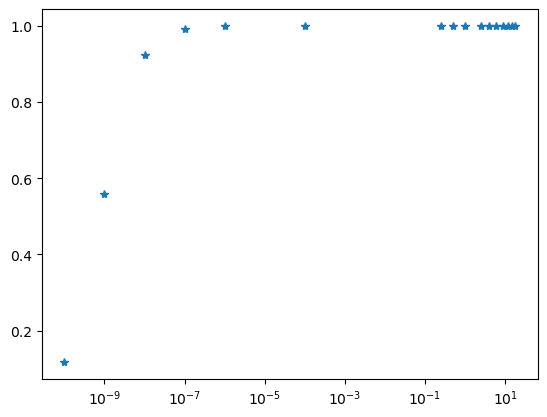

In [18]:
plt.semilogx(CO_df['Press'],CO_df['KMC_SS_Covg'],'*')

In [19]:
os.chdir('../')
os.getcwd()

'/Users/klkusima/Desktop/RASH_Research/CO_ox/Kinetics/OOP_Kinetics/MiKi/OOP7_Curve_Fit_OPTIM/CO_adsorption_desorption'

In [20]:
from main import *
MKM = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM.set_limits_of_integration(data_KMC_dict['sim_time'][0][0],data_KMC_dict['sim_time'][0][-1])

Mass is conserved. 



(0.0, 149.99999999999577)

In [21]:
MKM.Stoichiometric_numbers

[1.0]

In [22]:
%%time
from main import *
MKM = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM.set_limits_of_integration(data_KMC_dict['sim_time'][0][0],data_KMC_dict['sim_time'][0][-1])

MKM_SS_covg = []
Prs = CO_df['Press']
for i in np.arange(len(Prs)):
    MKM.set_rxnconditions(Pr=[Prs.iloc[i]])
    MKM_SS_covg = np.append(MKM_SS_covg,MKM.get_SS_coverages()[0])

Mass is conserved. 

Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
CPU times: user 2.61 s, sys: 20.5 ms, total: 2.63 s
Wall time: 2.62 s


Text(0, 0.5, 'CO Coverage, [ML]')

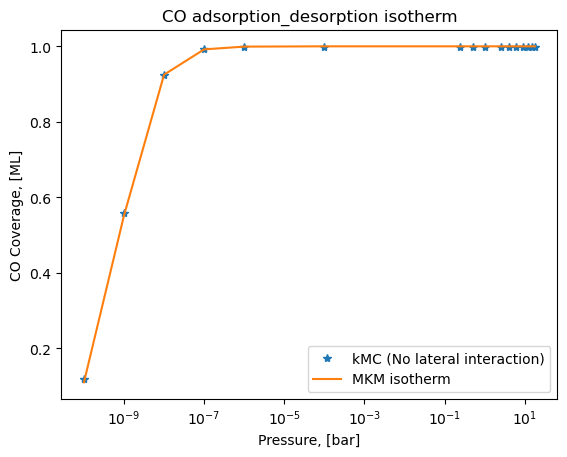

In [23]:
plt.figure()
plt.semilogx(CO_df['Press'],CO_df['KMC_SS_Covg'],'*',label='kMC (No lateral interaction)')
plt.semilogx(Prs,MKM_SS_covg,'-',label='MKM isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')

In [24]:
MKM.k

array([8.28e+07, 6.72e-02])

In [25]:
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil

In [26]:
os.getcwd()

'/Users/klkusima/Desktop/RASH_Research/CO_ox/Kinetics/OOP_Kinetics/MiKi/OOP7_Curve_Fit_OPTIM/CO_adsorption_desorption'

In [27]:
%%time
os.chdir('LATERAL')
Sim_folder_names = []
i = 0
for file in glob.glob("*bar"):
    Sim_folder_names.append(file)
    i+=1
print('Number of simulations:',i)
print(Sim_folder_names)
#os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

Number of simulations: 29
['1e-5bar', '5e-4bar', '2.5bar', '0.5e-3bar', '12.0bar', '2.0bar', '1e-4bar', '3.5bar', '0.25bar', '0.01bar', '0.005bar', '9.0bar', '4.5bar', '18.0bar', '0.125bar', '14.0bar', '1e-9bar', '2e-3bar', '7.5bar', '6.0bar', '1e-8bar', '16.0bar', '0.5bar', '1e-10bar', '10.5bar', '1e-7bar', '1.0bar', '1e-6bar', '1.5bar']
CPU times: user 734 µs, sys: 839 µs, total: 1.57 ms
Wall time: 952 µs


In [28]:
os.getcwd()

'/Users/klkusima/Desktop/RASH_Research/CO_ox/Kinetics/OOP_Kinetics/MiKi/OOP7_Curve_Fit_OPTIM/CO_adsorption_desorption/LATERAL'

In [29]:
os.chdir('../')
os.getcwd()

'/Users/klkusima/Desktop/RASH_Research/CO_ox/Kinetics/OOP_Kinetics/MiKi/OOP7_Curve_Fit_OPTIM/CO_adsorption_desorption'

In [30]:
os.chdir('LATERAL')
os.getcwd()

'/Users/klkusima/Desktop/RASH_Research/CO_ox/Kinetics/OOP_Kinetics/MiKi/OOP7_Curve_Fit_OPTIM/CO_adsorption_desorption/LATERAL'

In [31]:
#Checking to see match
## Copying all the other input files into the different simulation folders
# Extracting initial coverages
#Remember: A='CO*'; B='O*'
n_points = 7501 #From KMC simulation 
n_gas_species = 3 #From KMC simulation
n_surf_species = 4 #From KMC simulation

n_accept = []
Exp_init_coverages = np.empty([len(Sim_folder_names),n_surf_species])
c = 0 #counter
for s in Sim_folder_names:
    os.chdir(s)
    file=open('specnum_output.txt','r').readlines() #Reading in the relevant file
    b=[]
    for i in np.arange(len(file)): 
        b.append(file[i].split())                   #Dividing the rows into columns
    o = pd.DataFrame(data=b)                        #Final output

#     print(o)
    #Extracting Number of Sites from the general_output file:
    inp=open('general_output.txt','r').readlines()
    for i in np.arange(len(inp)): 
        if 'Total number of lattice sites:' in inp[i]:
            val = i  #Line in text file where sentence is present

    sites = int(inp[val][35:])
    
    #Finding number of surface species
    headings = (o.iloc[0,:])
    n_ss = sum('*' in h for h in headings) #Number of surface species
    
    #Finding number of gas species
    n_gs = len(headings)-5-n_ss
    
    #Adding column to calculate number of empty sites
    n_c=(len(o.iloc[0,:])) #number of current columns
    o[n_c]=" "           #Creating new empty column 
    o.iloc[0,n_c]="*"    #Labelling the new empty column 

    st = 0 #Initializing empty site coverage vector


    for i in range(len(o.iloc[1:])):
        if n_ss==0:
            site = sites
        else:
            for j in range(n_ss):
                st = st + float(o.iloc[i+1,5+j]) #Calculating no. of empty sites #Asuming empty sites are first to be reportes (i.e @5)
            site = sites - st
            st = 0
        o.iloc[i+1,n_c] = site
    
    Sspecies = []
    for i in range(n_ss):
        Sspecies.append(5+i) 
    Sspecies.append(len(o.iloc[1,:])-1)#Including empty sites

    #Calculating itme:
    Gtime = o[2][1:].astype(float) 
    #Calculating coverages:
    Scoverages = np.empty([len(o.iloc[:,1])-1,len(Sspecies)])
    for i in range(len(Scoverages[1,:])):
        Scoverages[:,i] = o[Sspecies[i]][1:].astype(float)/sites
    print(len(Scoverages))    
    if len(Scoverages)!=n_points: ###########MUST MATCH N_POINTS_SEE_ SPECNUM FILE #############################
        print(s) 
        n_accept = np.append(n_accept,s)
        Sim_folder_names = [element for element in Sim_folder_names if element != s]

    exp_init_covg = []
    for i in np.arange(n_surf_species):    #B_O*_covg,     A_CO*_covg,     O2*_covg, *_covg
        exp_init_covg.append(Scoverages[0,i])
        
    Exp_init_coverages[c,:] = exp_init_covg
    
    c+=1
    
    os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

7501
1001
5e-4bar
7501
7501
7501
7501
7501
7501
7501
7501
7501
7501
7501
7501
7501
7501
7501
7501
7501
7501
7501
7501
7501
7501
7501
7501
7501
7501
7501


***
<a id="2"></a> 
## 2. Developing ML Training Dataset for rate correction
<a href="#top">Back to top</a>

## Dictionary formats:

***
<a id="2.1"></a> 
## 2.A  Generating Experimental Data Dictionary
<a href="#top">Back to top</a>

In [32]:
os.getcwd()
os.chdir('../')
os.getcwd()
os.chdir('LATERAL')
os.getcwd()

'/Users/klkusima/Desktop/RASH_Research/CO_ox/Kinetics/OOP_Kinetics/MiKi/OOP7_Curve_Fit_OPTIM/CO_adsorption_desorption/LATERAL'

In [33]:
%%time
## Copying all the other input files into the different simulation folders
# Extracting initial coverages
#Remember: A='CO*'; B='O*'
n = len(Sim_folder_names)

Covg = np.zeros((n,n_points,n_surf_species)) #CO*, O*, O2*, *
Rates = np.zeros((n,n_points,n_gas_species)) #CO, O2, CO2
KMC_time_Array = np.zeros((n,n_points))
init_coverages = np.empty([n,n_surf_species])
c = 0 #counter for number of simulation (folders)

Press = []

for s in Sim_folder_names:
    os.chdir(s)
    file=open('specnum_output.txt','r').readlines() #Reading in the relevant file
    b=[]
    for i in np.arange(len(file)): 
        b.append(file[i].split())                   #Dividing the rows into columns
    o = pd.DataFrame(data=b)                        #Final output

#     print(o)
    #Extracting Number of Sites from the general_output file:
    inp=open('general_output.txt','r').readlines()
    for i in np.arange(len(inp)): 
        if 'Total number of lattice sites:' in inp[i]:
            val = i  #Line in text file where sentence is present

    sites = int(inp[val][34:])
    
    #Finding number of surface species
    headings = (o.iloc[0,:])
    n_ss = sum('*' in h for h in headings) #Number of surface species
    
    #Finding number of gas species
    n_gs = len(headings)-5-n_ss
    
    #Adding column to calculate number of empty sites
    n_c=(len(o.iloc[0,:])) #number of current columns
    o[n_c]=" "           #Creating new empty column 
    o.iloc[0,n_c]="*"    #Labelling the new empty column 

    st = 0 #Initializing empty site coverage vector


    for i in range(len(o.iloc[1:])):
        if n_ss==0:
            site = sites
        else:
            for j in range(n_ss):
                st = st + float(o.iloc[i+1,5+j]) #Calculating no. of empty sites #Asuming empty sites are first to be reportes (i.e @5)
            site = sites - st
            st = 0
        o.iloc[i+1,n_c] = site
    
    Sspecies = []
    for i in range(n_ss):
        Sspecies.append(5+i) 
    Sspecies.append(len(o.iloc[1,:])-1)#Including empty sites

    #Calculating itme:
    Gtime = o[2][1:].astype(float) 
    
    #Calculating coverages:
    Scoverages = np.empty([len(o.iloc[:,1])-1,len(Sspecies)])
    for i in range(len(Scoverages[1,:])):
        Scoverages[:,i] = o[Sspecies[i]][1:].astype(float)/sites


    Gspecies = []
    for i in range(n_gs):
        Gspecies.append(5+n_ss+i) 

    #Extracting the number of gas species molecules:    
    Gnmol = np.empty([len(o.iloc[:,1])-1,len(Gspecies)])
    for i in range(len(Gnmol[1,:])):
        Gnmol[:,i] = o[Gspecies[i]][1:].astype(float)

    ### Calculating the instantaneous rates of profuction (i.e grad/sites)
    TOF_GS = np.empty([len(o.iloc[:,1])-1,len(Gspecies)]) #initializing an array of instantaneous TOFs for gaseous species

    for i in np.arange(len(Gspecies)):
        grads = np.gradient(Gnmol[:,i],Gtime,edge_order=2)
        TOF_GS[:,i] = grads/sites


    #initializing TOF for gas species
    STOF = np.empty([n_points,n_gas_species])
    gs_names = (o.iloc[0,Gspecies].tolist())
    gs_names_colmn = []

    for i in np.arange(n_gas_species): #Collecting TOFs
        STOF[:,i] = pd.Series(TOF_GS[:,i])

    for i in gs_names: #Collecting gas names
        gs_names_colmn.append('R_'+i)

    Rates_p = pd.DataFrame(STOF,
                    columns = gs_names_colmn)

    init_covg = []
    for i in np.arange(n_surf_species):    #B_O*_covg,     A_CO*_covg,     O2*_covg, *_covg
        init_covg.append(Scoverages[0,i])

    init_coverages[c,:]= init_covg #Initial coverages

    KMC_time_Array[c,:]= Gtime #Time matrix

    Covg[c,:,:] = Scoverages #Coverage profile tensor

    Rates[c,:,:] = Rates_p

    c+=1
    
    Press = np.append(Press,s[:-3])
    os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir)) #Changes directory back to where this script is

#https://stackoverflow.com/questions/49881570/python-dictionaries-appending-arrays-to-a-dictionary-for-a-specific-key
data_KMC_dict_LAT = {'Pressure':Press, 'sim_time': KMC_time_Array, 'covg_prof': Covg, 'iRates': Rates}

CPU times: user 13.4 s, sys: 35.6 ms, total: 13.4 s
Wall time: 13.4 s


## Calculating the Steady States of each simulations

In [34]:
##CONVert prerssures from string to float (as inputed in kmc)
def convert_strings_to_floats(input_array):
    output_array = []
    for element in input_array:
        converted_float = float(element)
        output_array.append(converted_float)
    return output_array
input_array = list(Press)
output_array = convert_strings_to_floats(input_array)
len(output_array)

28

In [35]:
output_array = (np.array(output_array).astype(float))
output_array

data_KMC_dict_LAT['Pressure'] = output_array

In [36]:
SS_Coverages = []
##CALCULATING STEADY STATE COVERAGE (AVERAGED LAST 10%)
def check_SS(trans_vec,tol=0.10,feature=None): #Function for checking if steady state has been reached
    #trans_vector=transient vector #tol=tolerance value i.e what percent distance is between end and end_prev (0.1 means that end_prev is a value 10% away from end)
    length = np.shape(trans_vec)[0]
    end = trans_vec[-1,:]
    end_prev = trans_vec[-int(np.round(length*tol)),:]
    steady_diff = np.abs(end-end_prev)

    msg='Steady State Reached'
    if feature=='coverage': 
        if all(x < 1e-2 for x in steady_diff):
            return (end,msg)
        else:
            msg = 'Warning: STEADY STATE MAY NOT HAVE BEEN REACHED. Difference in a set of last two coverage terms is NOT less than 1e-2.Last terms are returned anyways.'
            return (end,msg)
        
for i in np.arange(np.shape(data_KMC_dict_LAT['covg_prof'])[0]):
    array_covg = data_KMC_dict_LAT['covg_prof'][i]
    end = check_SS(array_covg)
    tol = 0.1
    length = np.shape(array_covg)[0]
    summ = np.sum(array_covg[-int(np.round(length*tol)):,:], axis = 0)
    avg_ss = summ/(length*tol)
    SS_Coverages = np.append(SS_Coverages,avg_ss)

SS_Coverages = np.array(SS_Coverages)    

In [37]:
SS_Coverages = SS_Coverages.reshape(np.shape(data_KMC_dict_LAT['covg_prof'])[0],4)

In [38]:
CO_df_LAT = pd.DataFrame(output_array,columns= ['Press'])

In [39]:
CO_df_LAT['KMC_SS_Covg'] = pd.DataFrame(SS_Coverages[:,1])

In [40]:
CO_df_LAT =CO_df_LAT.sort_values(by='Press') #Sorting Dataframe according to ascending pressures
CO_df_LAT

,Press,KMC_SS_Covg
22,1.000000e-10,0.046330
15,1.000000e-09,0.091111
19,1.000000e-08,0.121996
24,1.000000e-07,0.143216
26,1.000000e-06,0.155425
0,1.000000e-05,0.163325
5,1.000000e-04,0.170389
2,5.000000e-04,0.175407
16,2.000000e-03,0.180016
9,5.000000e-03,0.184291


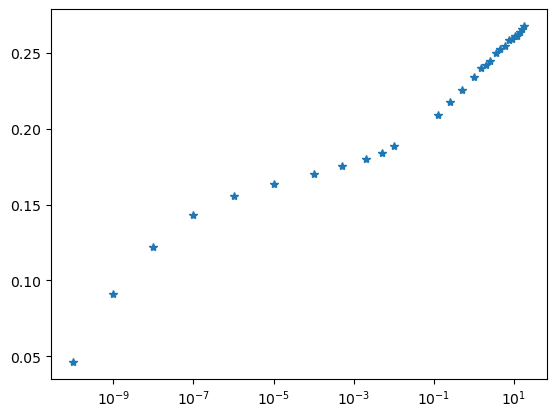

In [41]:
plt.semilogx(CO_df_LAT['Press'],CO_df_LAT['KMC_SS_Covg'],'*')

In [42]:
os.chdir('../')
os.getcwd()

'/Users/klkusima/Desktop/RASH_Research/CO_ox/Kinetics/OOP_Kinetics/MiKi/OOP7_Curve_Fit_OPTIM/CO_adsorption_desorption'

In [43]:
%%time
from main import *
MKM = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM.Thermo_Constraint = 'OFF'
MKM.set_limits_of_integration(data_KMC_dict_LAT['sim_time'][0][0],data_KMC_dict_LAT['sim_time'][0][-1])
MKM.rate_const_correction='None'
MKM_SS_covg_LAT = []
Prs = CO_df_LAT['Press']
for i in np.arange(len(Prs)):
    MKM.set_rxnconditions(Pr=[CO_df_LAT['Press'].iloc[i]])
    MKM_SS_covg_LAT = np.append(MKM_SS_covg_LAT,MKM.get_SS_coverages()[0])

Mass is conserved. 

Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
CPU times: user 4.71 s, sys: 62.3 ms, total: 4.77 s
Wall time: 4.73 s


<IPython.core.display.Javascript object>


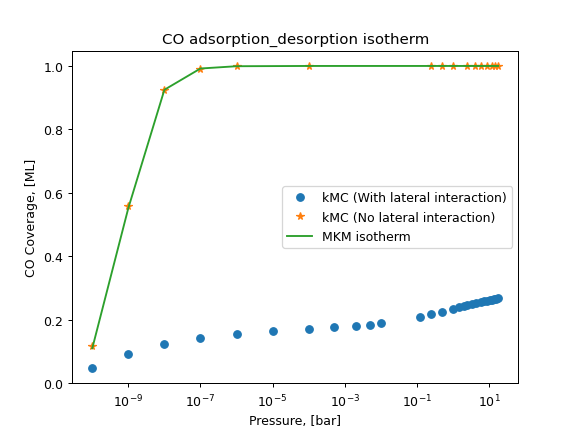

Text(0, 0.5, 'CO Coverage, [ML]')

In [44]:
%matplotlib notebook
plt.figure()
plt.semilogx(CO_df_LAT['Press'],CO_df_LAT['KMC_SS_Covg'],'o',label='kMC (With lateral interaction)')
plt.semilogx(CO_df['Press'],CO_df['KMC_SS_Covg'],'*',label='kMC (No lateral interaction)')
plt.semilogx(CO_df['Press'],MKM_SS_covg,'-',label='MKM isotherm')
# plt.semilogx(Prs,MKM_SS_covg_LAT,'-',label='MKM isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')

In [55]:
MKM.k
Keq = MKM.k[0]/MKM.k[1]
isoth = []
for i in (CO_df['Press']):
    isoth.append((Keq*i/(1+(Keq*i))))

<IPython.core.display.Javascript object>


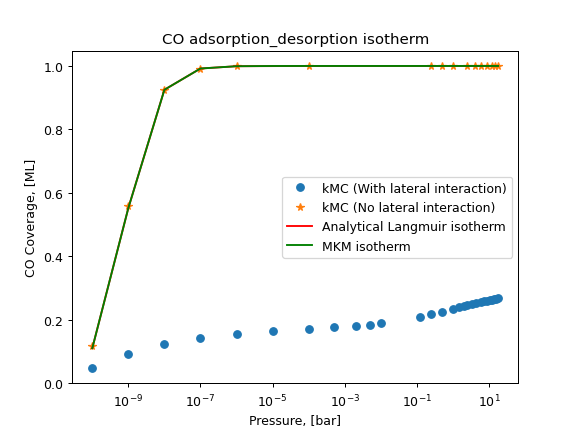

Text(0, 0.5, 'CO Coverage, [ML]')

In [66]:
plt.figure()
plt.semilogx(CO_df_LAT['Press'],CO_df_LAT['KMC_SS_Covg'],'o',label='kMC (With lateral interaction)')
plt.semilogx(CO_df['Press'],CO_df['KMC_SS_Covg'],'*',label='kMC (No lateral interaction)')
# plt.semilogx(CO_df['Press'],MKM_SS_covg,'-',label='MKM isotherm')
plt.semilogx(CO_df['Press'],isoth,'r-',label='Analytical Langmuir isotherm')
plt.semilogx(Prs,MKM_SS_covg_LAT,'g-',label='MKM isotherm')
plt.legend(loc ="center right")
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')

In [45]:
np.shape(MKM_SS_covg_LAT)

(28,)

In [46]:
def MKModelling_Press(*fit_params):
    MKM = MKModel('Atomic.csv','Stoich.csv','Param.csv')
    MKM.Thermo_Constraint = 'OFF'
    MKM.set_limits_of_integration(data_KMC_dict_LAT['sim_time'][0][0],data_KMC_dict_LAT['sim_time'][0][-1])
    MKM.rate_const_correction='None'
    MKM_SS_covg_LAT = []
    MKM.k = fit_params
    Prs = CO_df_LAT['Press']
    for i in np.arange(len(Prs)):
        MKM.set_rxnconditions(Pr=[Prs.iloc[i]])
        MKM_SS_covg_LAT = np.append(MKM_SS_covg_LAT,MKM.get_SS_coverages(print_warning=False)[0])
        
    return MKM_SS_covg_LAT

In [47]:
%%time
### Fitting rate constant function due to the feature = iRates
def MKM_k_fitting(x,*fit_params):
    data_MKM_dict  = MKModelling_Press(*fit_params)    
    return np.reshape(data_MKM_dict,data_MKM_dict.size)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [48]:
%%time
x_values = CO_df_LAT['Press']
y_values = np.reshape(CO_df_LAT['KMC_SS_Covg'],CO_df_LAT['KMC_SS_Covg'].size) #Normalized Input Dependent variable(s) (eg. KMC coverages)

initial_vals = np.array([8.28E+07,6.72E-02])

params, params_covariance = optimize.curve_fit(MKM_k_fitting, x_values, y_values
                                            ,method = 'trf', bounds=(0,1e12), maxfev=1e3, xtol=1e-3, ftol=1e-3
                                            ,p0=initial_vals)

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

CPU times: user 27 s, sys: 81.6 ms, total: 27.1 s
Wall time: 27.2 s


In [49]:
print(params)

[8.28095788e+07 2.30322099e-01]


In [50]:
%%time
from main import *
MKM = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM.Thermo_Constraint = 'OFF'
MKM.set_limits_of_integration(data_KMC_dict_LAT['sim_time'][0][0],data_KMC_dict_LAT['sim_time'][0][-1])
MKM.rate_const_correction='None'
MKM_SS_covg_LAT = []
MKM.k = np.array(params)
Prs = CO_df_LAT['Press']
for i in np.arange(len(Prs)):
    MKM.set_rxnconditions(Pr=[CO_df_LAT['Press'].iloc[i]])
    MKM_SS_covg_LAT = np.append(MKM_SS_covg_LAT,MKM.get_SS_coverages(print_warning=False)[0])

Mass is conserved. 

CPU times: user 4.52 s, sys: 14.3 ms, total: 4.54 s
Wall time: 4.55 s


<IPython.core.display.Javascript object>


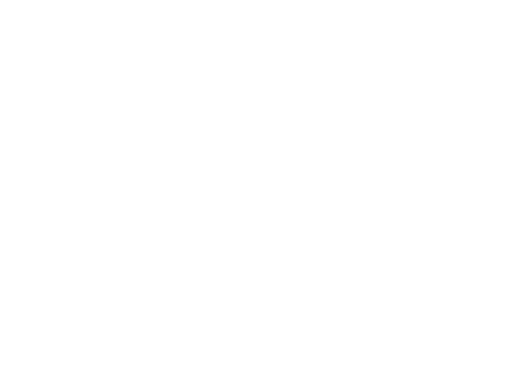

Text(0, 0.5, 'CO Coverage, [ML]')

In [51]:
%matplotlib notebook
plt.figure()
plt.semilogx(CO_df_LAT['Press'],CO_df_LAT['KMC_SS_Covg'],'o',label='kMC (With lateral interaction)')
plt.semilogx(CO_df['Press'],CO_df['KMC_SS_Covg'],'*',label='kMC (No lateral interaction)')
plt.semilogx(CO_df['Press'],MKM_SS_covg,'-',label='MKM isotherm')
plt.semilogx(CO_df_LAT['Press'],MKM_SS_covg_LAT,'--',label='MKM lateral isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')

In [52]:
### PErforming Fitting with NLLS

In [53]:
time = data_KMC_dict_LAT['sim_time'][0]

In [54]:
MKM.k

array([8.28095788e+07, 2.30322099e-01])

In [55]:
def cost_func(x,*fit_params): #cost function for non-dynamic kmc #covg and instantaneous gasseous rates of prod
        
    MKM = MKModel('Atomic.csv','Stoich.csv','Param.csv')
    MKM.Thermo_Constraint = 'OFF'
    MKM.set_limits_of_integration(time[0],time[-1])
    MKM.rate_const_correction='None'
    MKM_SS_covg_LAT = []
    
    MKM.k[0]=fit_params[0]
    MKM.k[1]=fit_params[1]
    
    Prs = CO_df_LAT['Press']
    for i in np.arange(len(Prs)):
        MKM.set_rxnconditions(Pr=[CO_df_LAT['Press'].iloc[i]])
        MKM_SS_covg_LAT = np.append(MKM_SS_covg_LAT,MKM.get_SS_coverages(print_warning=False)[0])


    return MKM_SS_covg_LAT

In [76]:
%%time
# def curve_fit_func(method,maxfev,xtol,ftol):


method = 'trf'
maxfev = 1e5
xtol = 1e-1
ftol = 1e-1


x_values = CO_df_LAT['Press'] # Input Time variables (Independent Variable) (eg. KMC Time)

y_values = CO_df_LAT['KMC_SS_Covg']


initial_vals = [50e7,5e-1]

bnds = (0,1e20)

#Converting data from mpmath to float so as to have easy implimentation on fitting packages like curvefit.
x_values = [float(x) for x in x_values]
y_values = [float(x) for x in y_values]
initial_vals = [float(x) for x in initial_vals]

params, params_covariance = optimize.curve_fit(cost_func, x_values, y_values
                                            ,method =method, bounds=bnds, maxfev=maxfev, xtol=xtol, ftol=ftol
                                            ,p0=initial_vals)

print(params)

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

[5.00000000e+08 1.68148355e+00]
CPU times: user 27.1 s, sys: 89.5 ms, total: 27.2 s
Wall time: 27.4 s


In [77]:
MKM = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM.Thermo_Constraint = 'OFF'
MKM.set_limits_of_integration(time[0],time[-1])
MKM.rate_const_correction='None'
MKM_SS_covg_LAT_fit = []

MKM.k[0]=params[0]
MKM.k[1]=params[1]

Prs = CO_df_LAT['Press']
for i in np.arange(len(Prs)):
    MKM.set_rxnconditions(Pr=[CO_df_LAT['Press'].iloc[i]])
    MKM_SS_covg_LAT_fit = np.append(MKM_SS_covg_LAT_fit,MKM.get_SS_coverages()[0])


Mass is conserved. 

Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached


<IPython.core.display.Javascript object>


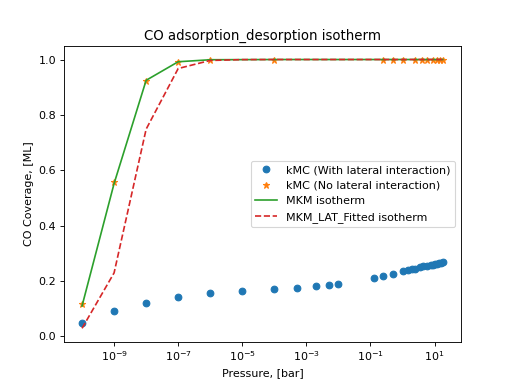

Text(0, 0.5, 'CO Coverage, [ML]')

In [78]:
%matplotlib notebook
plt.figure()
plt.semilogx(CO_df_LAT['Press'],CO_df_LAT['KMC_SS_Covg'],'o',label='kMC (With lateral interaction)')
plt.semilogx(CO_df['Press'],CO_df['KMC_SS_Covg'],'*',label='kMC (No lateral interaction)')
plt.semilogx(CO_df['Press'],MKM_SS_covg,'-',label='MKM isotherm')
plt.semilogx(CO_df_LAT['Press'],MKM_SS_covg_LAT_fit,'--',label='MKM_LAT_Fitted isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')

# USING DUAL ANNEALING

In [106]:
def error_fun(fit_params):
    y_estim = cost_func(1,*list(fit_params))
    y_data = CO_df_LAT['KMC_SS_Covg']
    return np.sqrt(np.sum((y_data - y_estim) ** 2))

In [111]:
%%time
from scipy.optimize import dual_annealing    
# x_values = CO_df_LAT['Press'] # Input Time variables (Independent Variable) (eg. KMC Time)

# y_values = CO_df_LAT['KMC_SS_Covg']
Guessk = np.array([50e7,5e-1])

#max K Guess parameters
sc = 1e8 #scaling value
mkval = Guessk*sc #max kvals
bounds = np.empty([len(mkval),2])
for i in range(len(mkval)):
    bounds[i] = (0,mkval[i])
    
res_d = dual_annealing(error_fun,bounds=bounds,
                     maxiter=20, maxfun = 5000, seed=45,x0=Guessk)

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 

Mass is conserved. 



KeyboardInterrupt: 

In [115]:
params = res_d.x
params

array([4.4005597e+08, 5.0000000e+01])

In [113]:
MKM = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM.Thermo_Constraint = 'OFF'
MKM.set_limits_of_integration(time[0],time[-1])
MKM.rate_const_correction='None'
MKM_SS_covg_LAT_fit = []

MKM.k[0]=params[0]
MKM.k[1]=params[1]

Prs = CO_df_LAT['Press']
for i in np.arange(len(Prs)):
    MKM.set_rxnconditions(Pr=[CO_df_LAT['Press'].iloc[i]])
    MKM_SS_covg_LAT_fit = np.append(MKM_SS_covg_LAT_fit,MKM.get_SS_coverages()[0])

Mass is conserved. 

Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached
Steady State Reached


<IPython.core.display.Javascript object>


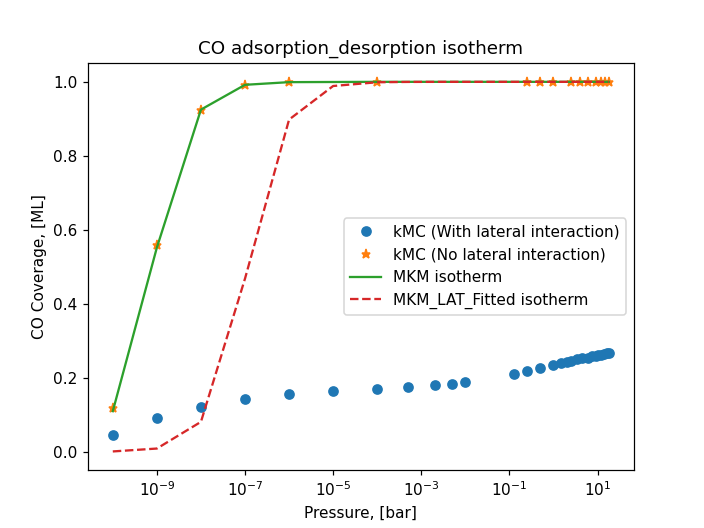

Text(0, 0.5, 'CO Coverage, [ML]')

In [114]:
%matplotlib notebook
plt.figure()
plt.semilogx(CO_df_LAT['Press'],CO_df_LAT['KMC_SS_Covg'],'o',label='kMC (With lateral interaction)')
plt.semilogx(CO_df['Press'],CO_df['KMC_SS_Covg'],'*',label='kMC (No lateral interaction)')
plt.semilogx(CO_df['Press'],MKM_SS_covg,'-',label='MKM isotherm')
plt.semilogx(CO_df_LAT['Press'],MKM_SS_covg_LAT_fit,'--',label='MKM_LAT_Fitted isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')